### Importing necesaary packages (including Snowpark)


In [1]:
# Snowpark
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.types import *
from snowflake.snowpark.version import VERSION
from snowflake.snowpark.functions import pandas_udf

# Pandas & json
import pandas as pd
import numpy as np
import json

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

%matplotlib inline

### Set context

In [2]:
# Read credentials
with open('creds.json') as f:
    connection_parameters = json.load(f)    
session = Session.builder.configs(connection_parameters).create()

In [3]:
snowpark_version = VERSION
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Role                        : {}'.format(session.get_current_role()))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

Database                    : "STROKE_DB"
Schema                      : "STROKE_SCHEMA"
Warehouse                   : "STROKE_WH"
Role                        : "ACCOUNTADMIN"
Snowpark for Python version : 1.0.0


### Data Loading

In [4]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


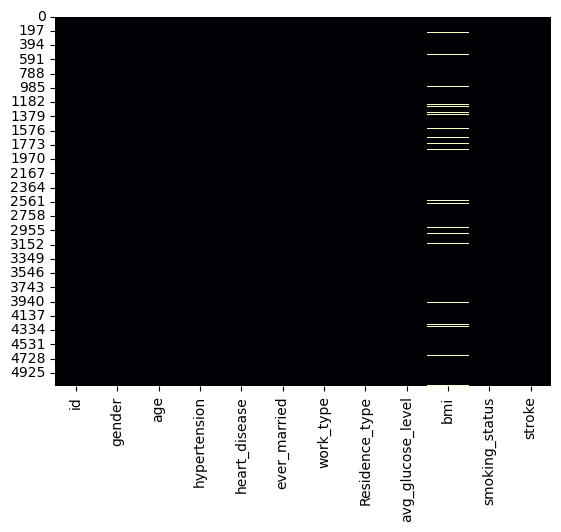

In [6]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False);

### Custom Palette For Visualization

In [7]:
sns.set_style("white")
sns.set(rc={"axes.facecolor":"#E8CE9D","figure.facecolor":"#E8CE9D","grid.color":"white"})
sns.set_context("poster",font_scale = .7)

#palette = ["#432C0A","#f7941d","#6c9a76","#f25a29","#cc4b57"]
palette = ["#764a23","#f7941d","#6c9a76","#f25a29","#cc4b57"]
palette_cmap = ["#6c9a76","#cc4b57","#764a23","#f25a29","#f7941d"]

# sns.palplot(sns.color_palette(palette))
# sns.palplot(sns.color_palette(palette_cmap))
# plt.show()

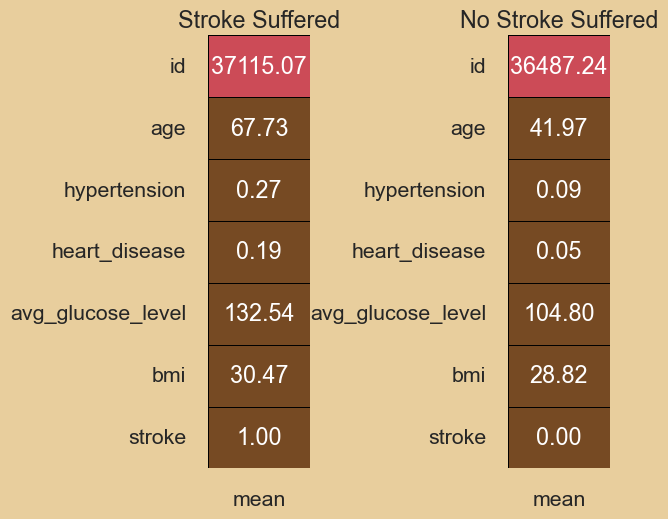

In [8]:
stroke = data[data['stroke'] == 1].describe().T
no_stroke = data[data['stroke'] == 0].describe().T

# colors = ['#3C1053','#DF6589']

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (6,5))
plt.subplot(1,2,1)
sns.heatmap(stroke[['mean']],annot = True,cmap = palette,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('Stroke Suffered');

plt.subplot(1,2,2)
sns.heatmap(no_stroke[['mean']],annot = True,cmap =palette,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('No Stroke Suffered');

fig.tight_layout(pad = 0)

- **A few null values** are present in the **bmi** feature!
- **Mean** values of all the features for cases of stroke suffered and no stroke suffered.
- age and avg_glucose_level can be solid 1st hand indicators to identify a stroke.
- Mean age values of patients that suffered a stroke, 67.73,is much higher than those did not suffer a stroke, 41.97.
- Similarly, avg_glucose_level value of 132.54 can indicate a higher chance of suffering from stroke than the avg_glucose_level value of 104.80 that has been found in patients that did not suffer a stroke.

### Fill Missing Values :

In [9]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


- From the table of descriptive statistics, we observe that mean and median values of **bmi** are very close to each other.
- Hence, we will fill the missing values with the **mean values**.

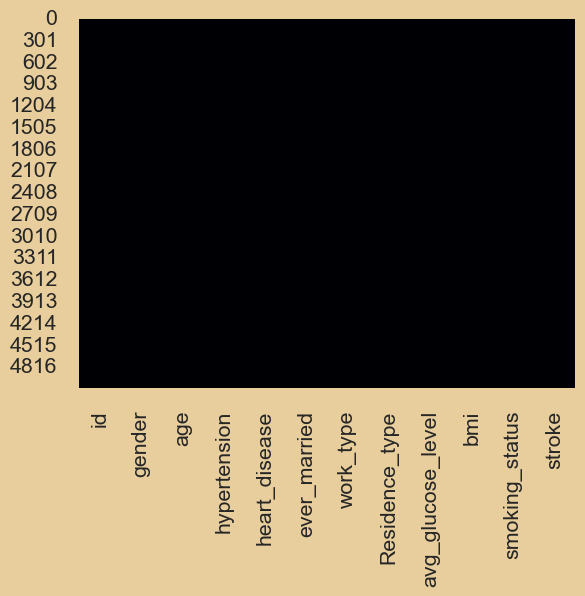

In [10]:
data['bmi'].fillna(data['bmi'].mean(),inplace = True)
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False);

Let's have a look on the distribution of stroke patient's age :


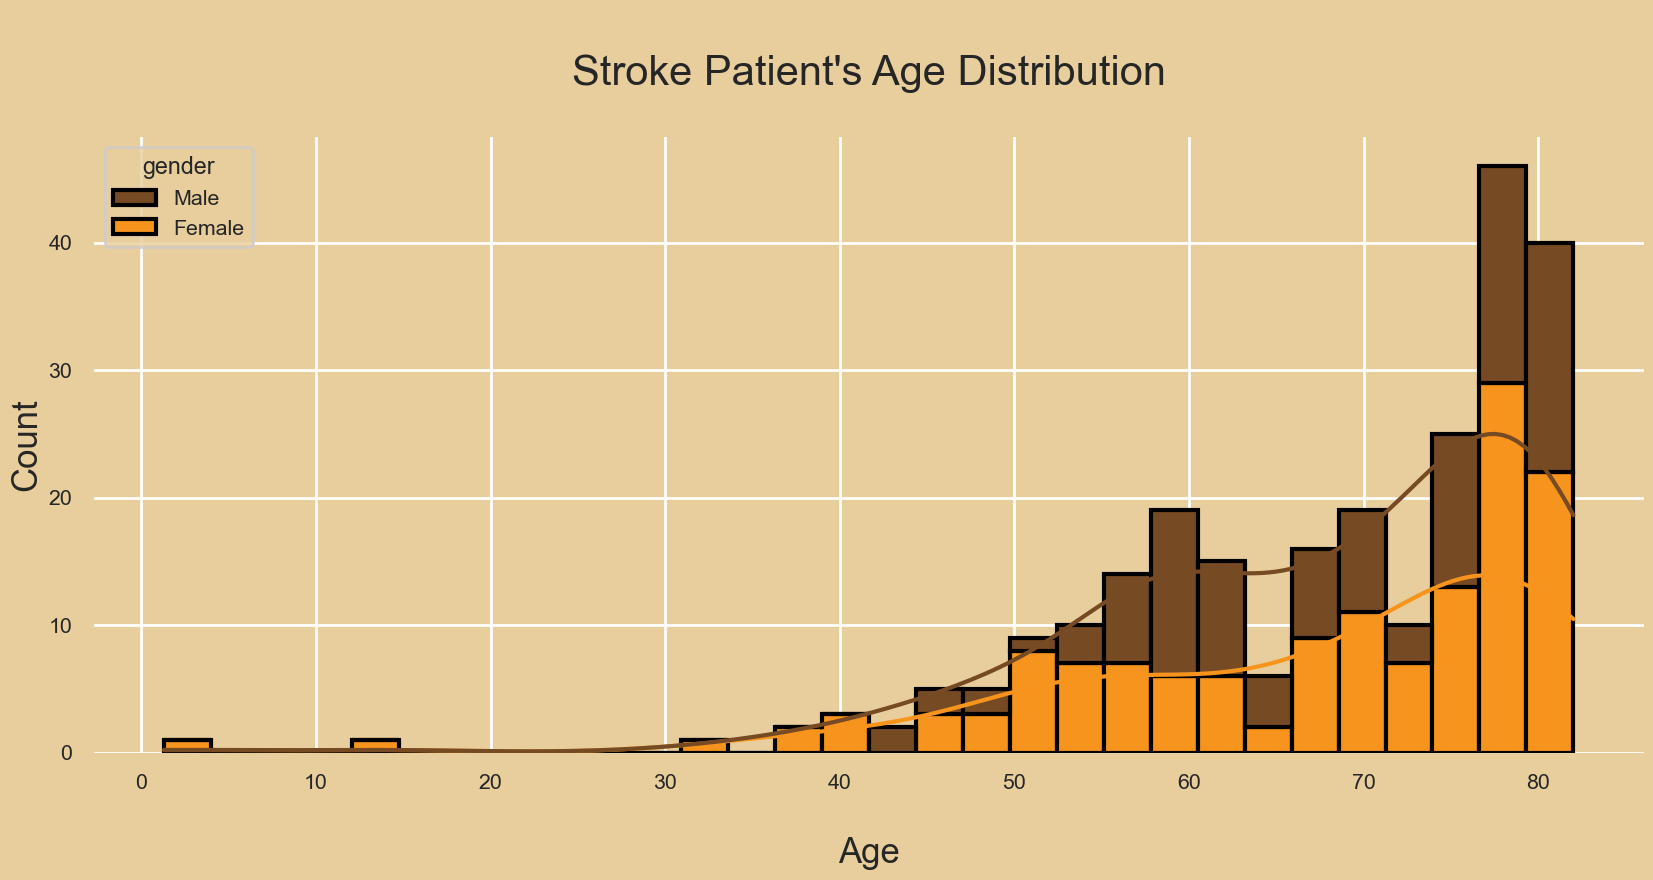

In [11]:
print(f"Let's have a look on the distribution of stroke patient's age :")
plt.subplots(figsize=(20, 8))
p = sns.histplot(data=data[data["stroke"] == 1],x="age",hue="gender",multiple="stack",palette=palette[0:2],kde=True,bins=30,alpha=1,fill=True,edgecolor="black",linewidth=3)
p.axes.lines[0].set_color(palette[1])
p.axes.lines[1].set_color(palette[0])
p.axes.set_title("\nStroke Patient's Age Distribution\n",fontsize=30)
p.set_ylabel("Count",fontsize=25)
p.set_xlabel("\nAge",fontsize=25)
p.set_yscale("linear")
sns.despine(left=True, bottom=True)

plt.show()

**Insights:**

* We can see the stroke patient's age distribution is left skewed. Most of the patients  fall in between **60 years** to **82 years**.
* Also there are some young and children female stroke patients too.

In [12]:
data.describe(include=object).T.style.set_properties(**{"background-color": "#c69c6c","color":"#432C0A","border": "1.5px #432C0A"})

,count,unique,top,freq
gender,5110,3,Female,2994
ever_married,5110,2,Yes,3353
work_type,5110,5,Private,2925
Residence_type,5110,2,Urban,2596
smoking_status,5110,4,never smoked,1892


Let's have a look on the distribution of genderwise stroke patient's age :


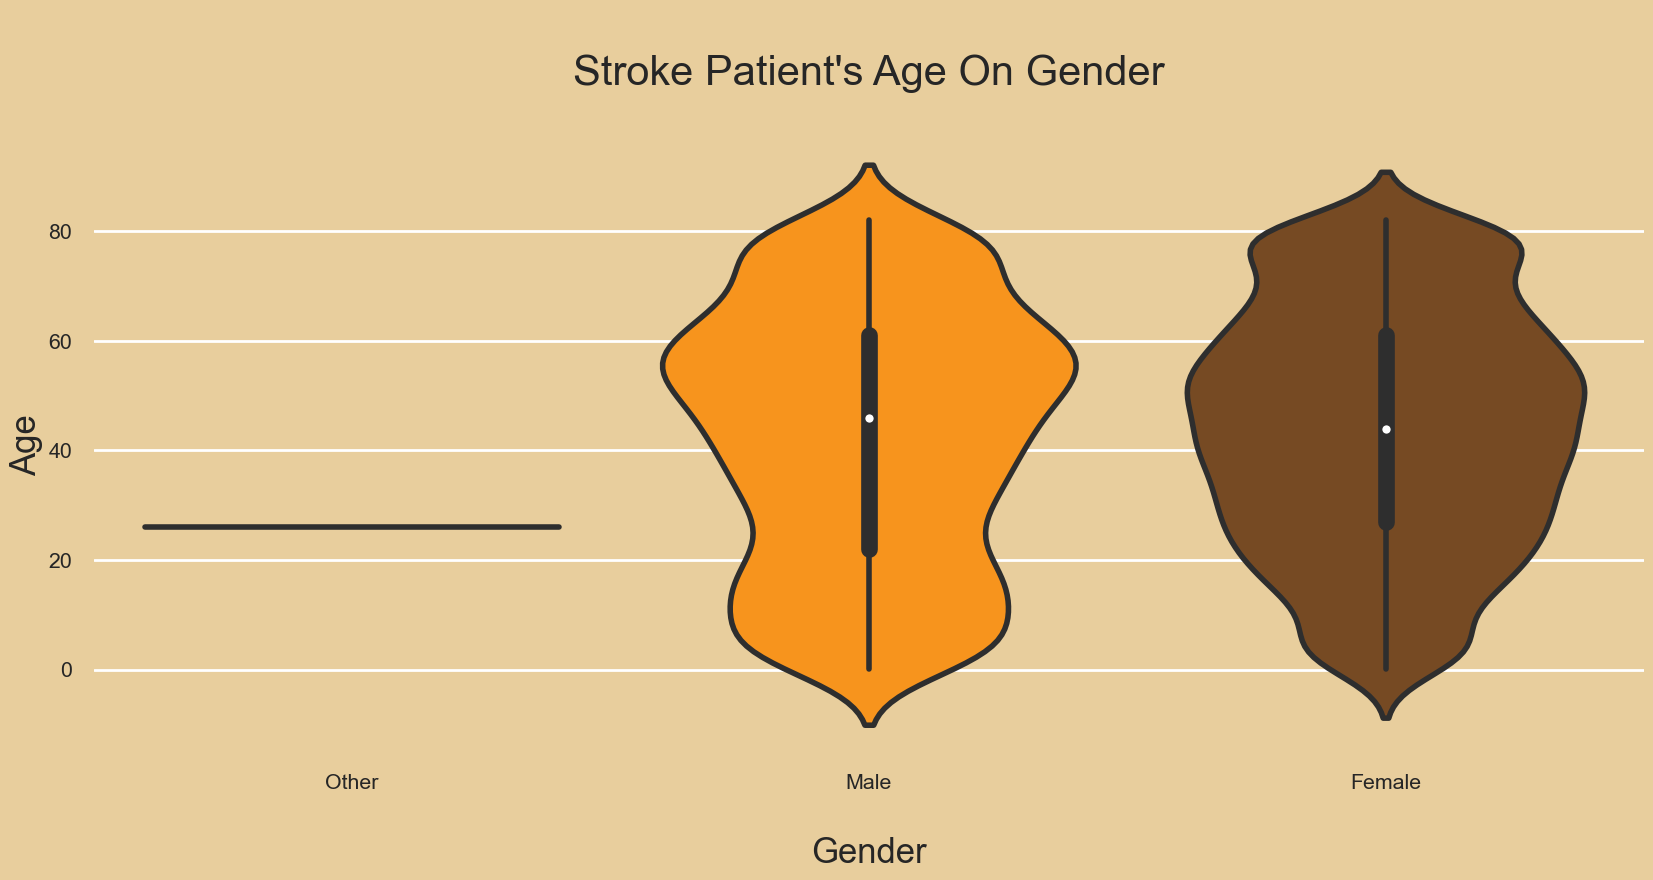

In [13]:
print("Let's have a look on the distribution of genderwise stroke patient's age :")
plt.subplots(figsize=(20, 8))

p=sns.violinplot(data=data[data["stroke"] == 1],x=data["gender"],y=data["age"],order=data["gender"].value_counts(ascending=True).index,palette=palette[0:2],saturation=1,linewidth=4,edgecolor="black")
p.axes.set_title("\nStroke Patient's Age On Gender\n",fontsize=30)
p.axes.set_xlabel("\nGender",fontsize=25)
p.axes.set_ylabel("Age",fontsize=25)

sns.despine(left=True, bottom=True)
plt.show()

Let's have a look on the ratio of stroke patient's gender :


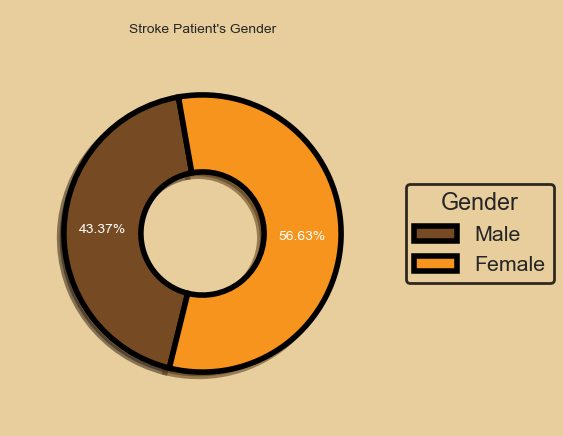

In [14]:
print(f"Let's have a look on the ratio of stroke patient's gender :")
plt.subplots(figsize=(5, 5))

labels = "Male","Female"
size = 0.5

wedges, texts, autotexts = plt.pie([data[data["stroke"] == 1]["gender"].value_counts(ascending=True).values[0],
                                    data[data["stroke"] == 1]["gender"].value_counts(ascending=True).values[1]],
                                    explode = (0,0),
                                    textprops=dict(size= 10, color= "white"),
                                    autopct="%.2f%%", 
                                    pctdistance = 0.72,
                                    radius=.9, 
                                    colors = palette[0:2], 
                                    shadow = True,
                                    wedgeprops=dict(width = size, edgecolor = "black", 
                                    linewidth = 4),
                                    startangle = 100)

plt.legend(wedges, labels, title="Gender",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1), edgecolor = "black")
plt.title("\nStroke Patient's Gender",fontsize=10)
plt.show()

**Insights:**

* Most of the stroke patients are **Female** with a ratio of **57.42%** followed by **Male** with a ratio of **42.58%**

Let's have a look on the stroke patient's smoking status :


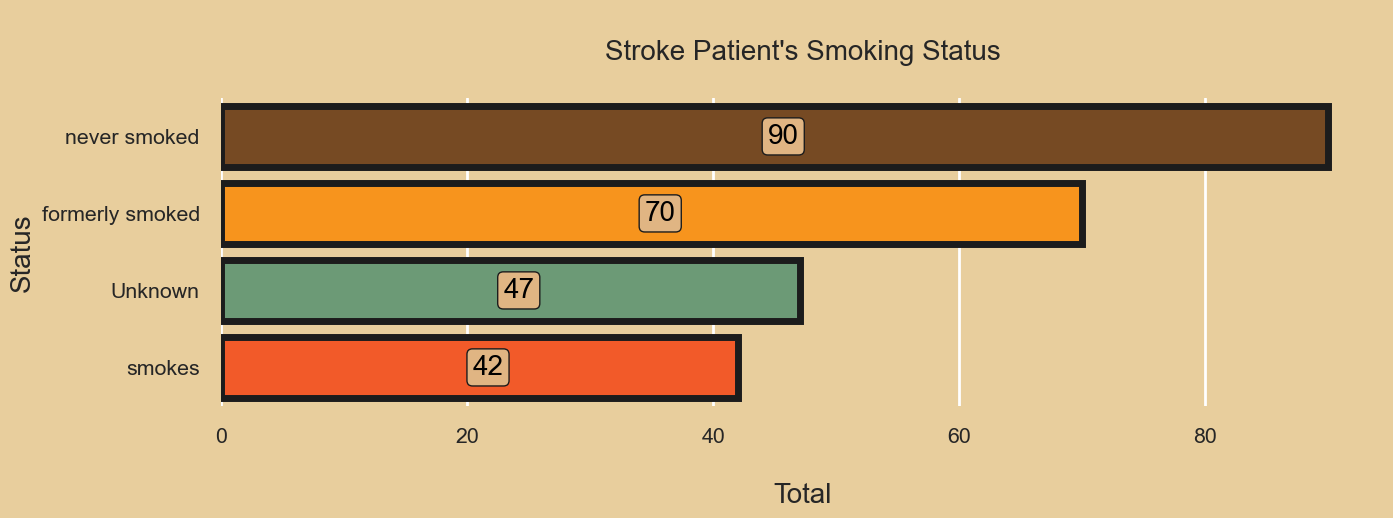

In [15]:
print("Let's have a look on the stroke patient's smoking status :")
plt.subplots(figsize=(15, 4))
p=sns.countplot(y=data[data["stroke"]==1]["smoking_status"],order=data[data["stroke"]==1]["smoking_status"].value_counts(ascending=False).index,palette=palette[0:4], saturation=1, edgecolor = "#1c1c1c", linewidth = 5)
# p.axes.set_yscale("symlog")
p.axes.set_title("\nStroke Patient's Smoking Status\n",fontsize=20)
p.axes.set_ylabel("Status",fontsize=20)
p.axes.set_xlabel("\nTotal",fontsize=20)
p.axes.set_yticklabels(p.get_yticklabels(),rotation = 0)
for container in p.containers:
    p.bar_label(container,label_type="center",padding=6,size=20,color="black",rotation=0,
    bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": "#1c1c1c", "linewidth" : 1, "alpha": 1})


sns.despine(left=True, bottom=True)
plt.show()

Let's have a look on the stroke patient's marital status :


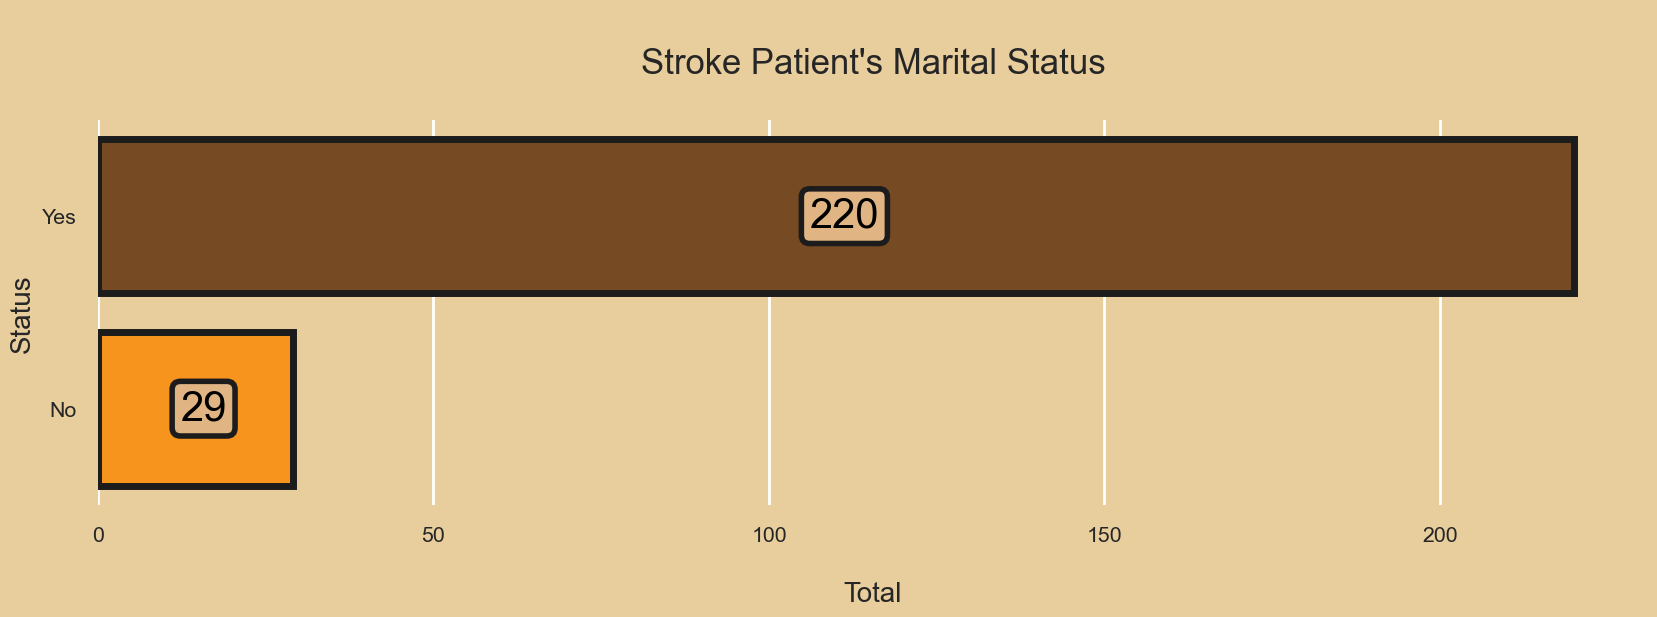

In [16]:
print("Let's have a look on the stroke patient's marital status :")
plt.subplots(figsize=(20, 5))
p=sns.countplot(y=data[data["stroke"]==1]["ever_married"],order=data[data["stroke"]==0]["ever_married"].value_counts(ascending=False).index,palette=palette[0:2], saturation=1, edgecolor = "#1c1c1c", linewidth = 5)
# p.axes.set_yscale("symlog")
p.axes.set_title("\nStroke Patient's Marital Status\n",fontsize=25)
p.axes.set_ylabel("Status",fontsize=20)
p.axes.set_xlabel("\nTotal",fontsize=20)
p.axes.set_yticklabels(p.get_yticklabels(),rotation = 0)
for container in p.containers:
    p.bar_label(container,label_type="center",padding=6,size=30,color="black",rotation=0,
    bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": "#1c1c1c", "linewidth" : 4, "alpha": 1})


sns.despine(left=True, bottom=True)
plt.show()

Let's have a look on the distribution of stroke patient's BMI :


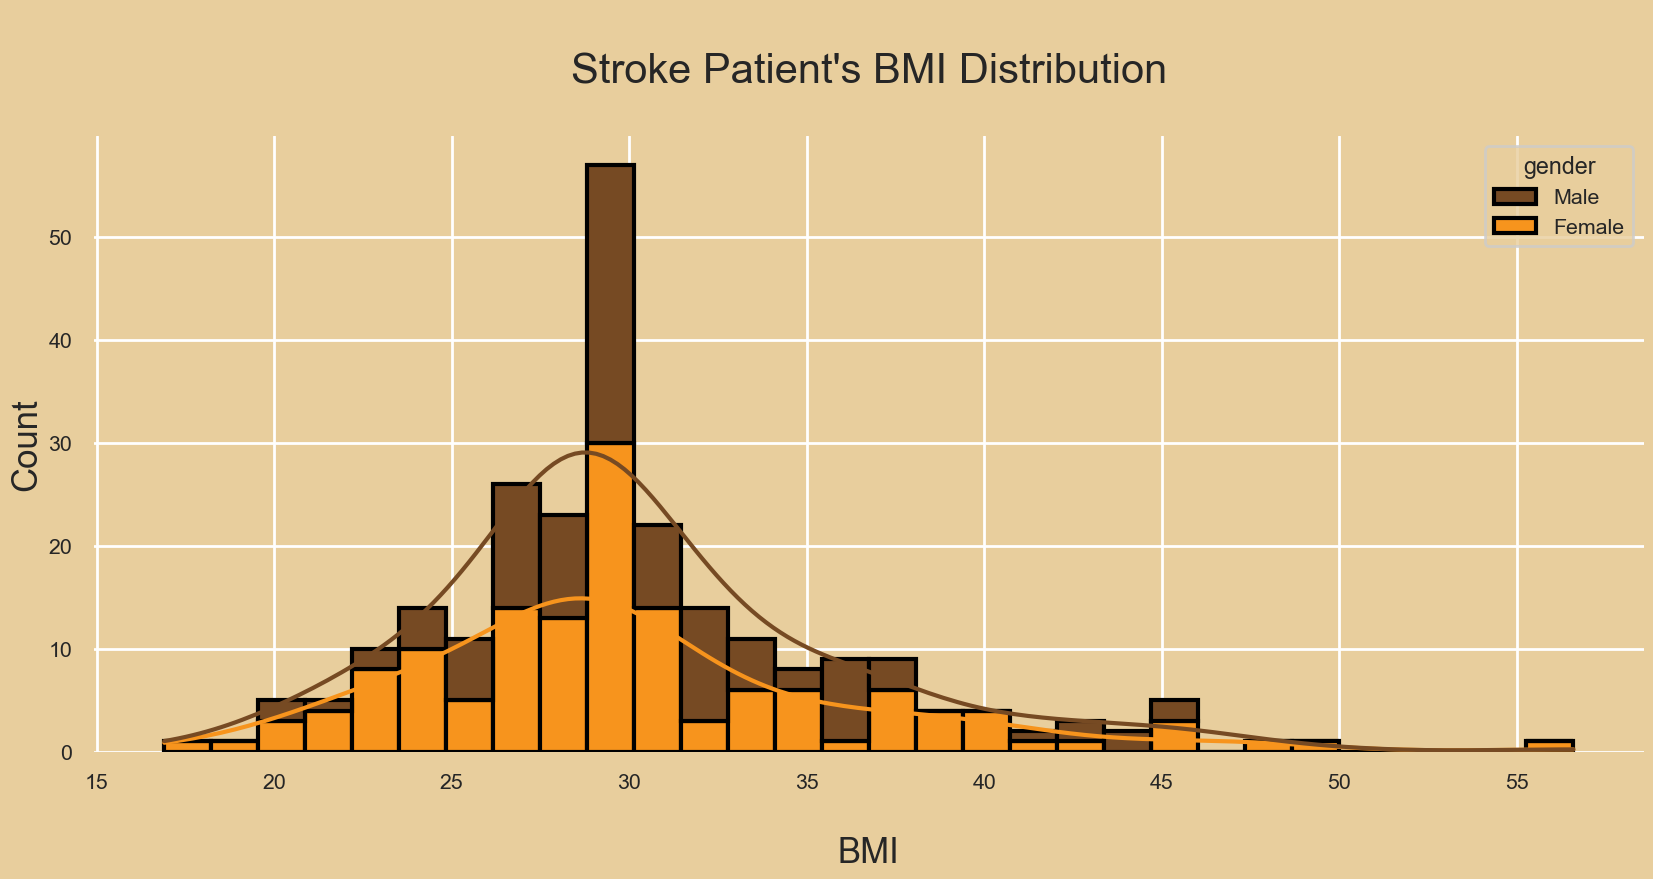

In [17]:
print(f"Let's have a look on the distribution of stroke patient's BMI :")
plt.subplots(figsize=(20, 8))
p = sns.histplot(data=data[data["stroke"] == 1],x="bmi",hue="gender",multiple="stack",palette=palette[0:2],kde=True,bins=30,alpha=1,fill=True,edgecolor="black",linewidth=3)
p.axes.lines[0].set_color(palette[1])
p.axes.lines[1].set_color(palette[0])
p.axes.set_title("\nStroke Patient's BMI Distribution\n",fontsize=30)
p.set_ylabel("Count",fontsize=25)
p.set_xlabel("\nBMI",fontsize=25)
p.set_yscale("linear")
sns.despine(left=True, bottom=True)

plt.show()

Let's have a look on the ratio of stroke patient's heart disease :


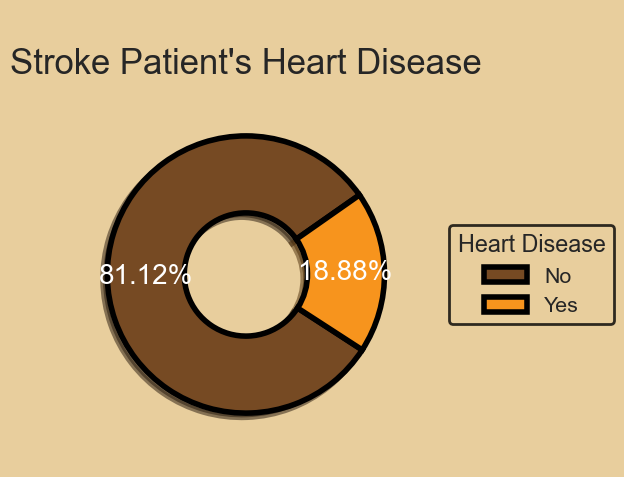

In [18]:
print(f"Let's have a look on the ratio of stroke patient's heart disease :")
plt.subplots(figsize=(5, 5))

labels = "No","Yes"
size = 0.5

wedges, texts, autotexts = plt.pie([data[data["stroke"] == 1]["heart_disease"].value_counts(ascending=False).values[0],
                                    data[data["stroke"] == 1]["heart_disease"].value_counts(ascending=False).values[1]],
                                    explode = (0,0),
                                    textprops=dict(size= 20, color= "white"),
                                    autopct="%.2f%%", 
                                    pctdistance = 0.72,
                                    radius=.9, 
                                    colors = palette[0:2], 
                                    shadow = True,
                                    wedgeprops=dict(width = size, edgecolor = "black", 
                                    linewidth = 4),
                                    startangle = 35)

plt.legend(wedges, labels, title="Heart Disease",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1), edgecolor = "black")
plt.title("\nStroke Patient's Heart Disease",fontsize=25)
plt.show()

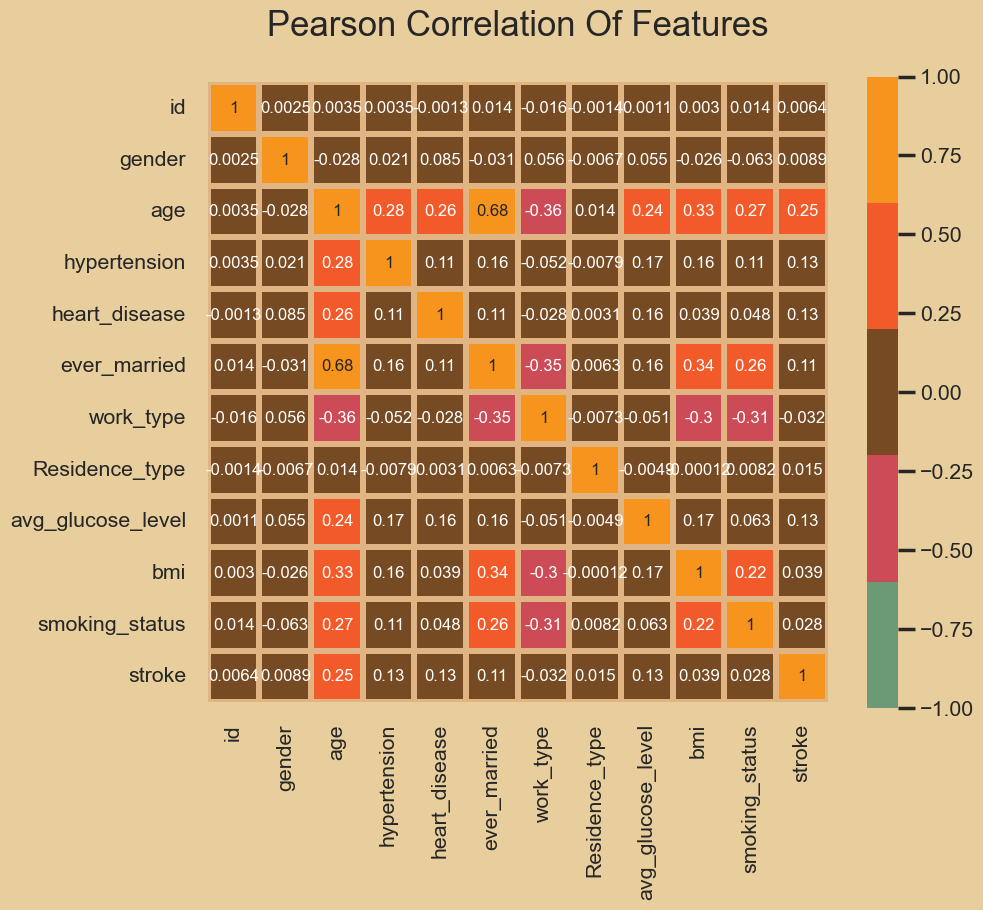

In [20]:
# conda install tqdm
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
catcol = [col for col in data.columns if data[col].dtype == "object"]
le = LabelEncoder()
for col in catcol:
        data[col] = le.fit_transform(data[col])


plt.subplots(figsize =(10, 10))

sns.heatmap(data.corr(), cmap = palette_cmap, square=True, cbar_kws=dict(shrink =.82), 
            annot=True, vmin=-1, vmax=1, linewidths=3,linecolor='#e0b583',annot_kws=dict(fontsize =12))
plt.title("Pearson Correlation Of Features\n", fontsize=25)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [21]:
data.drop(columns = ['id'],inplace = True)
col = list(data.columns)
categorical_features = []
discrete_features = []
for i in col:
    if len(data[i].unique()) > 6:
        discrete_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Discrete Features :',*discrete_features)

data['age'] = data['age'].astype(int)
df1 = data.copy(deep = True)

Categorical Features : gender hypertension heart_disease ever_married work_type Residence_type smoking_status stroke
Discrete Features : age avg_glucose_level bmi


In [22]:
le = LabelEncoder()
text_data_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
l3 = []; l4 = [];
print('Label Encoder Transformation')
for i in tqdm(text_data_features):
    df1[i] = le.fit_transform(df1[i])
    l3.append(list(df1[i].unique())); l4.append(list(le.inverse_transform(df1[i].unique())))
    print(i,' : ',df1[i].unique(),' = ',le.inverse_transform(df1[i].unique()))

Label Encoder Transformation


100%|██████████| 5/5 [00:00<00:00, 153.79it/s]

gender  :  [1 0 2]  =  [1 0 2]
ever_married  :  [1 0]  =  [1 0]
work_type  :  [2 3 0 4 1]  =  [2 3 0 4 1]
Residence_type  :  [1 0]  =  [1 0]
smoking_status  :  [1 2 3 0]  =  [1 2 3 0]


In [23]:
tf1 = {}
for i in range(len(text_data_features)):
    tf1[text_data_features[i]] = {}
    for j,k in zip(l3[i],l4[i]):
        tf1[text_data_features[i]][j] = k

tf1['hypertension'] = {0 : 'No Hypertension', 1 : 'Hypertension'} 
tf1['heart_disease'] = {0 : 'No Heart Disease', 1 : 'Heart Disease'}
tf1

{'gender': {1: 1, 0: 0, 2: 2},
 'ever_married': {1: 1, 0: 0},
 'work_type': {2: 2, 3: 3, 0: 0, 4: 4, 1: 1},
 'Residence_type': {1: 1, 0: 0},
 'smoking_status': {1: 1, 2: 2, 3: 3, 0: 0},
 'hypertension': {0: 'No Hypertension', 1: 'Hypertension'},
 'heart_disease': {0: 'No Heart Disease', 1: 'Heart Disease'}}

### Target Variable Visualization (stroke) : 

/var/folders/7_/dz3yj_1n1rqbtq3n6qnnktsh0000gn/T/ipykernel_13646/3306256151.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,1,1)


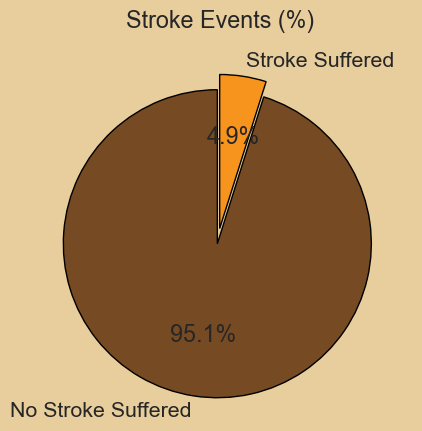

In [26]:
l = list(df1['stroke'].value_counts())
circle = [l[0] / sum(l) * 100,l[1] / sum(l) * 100]

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,5))
plt.subplot(1,1,1)
plt.pie(circle,labels = ['No Stroke Suffered','Stroke Suffered'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = palette,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Stroke Events (%)');

# plt.subplot(1,2,2)
# ax = sns.countplot('stroke',data = df1, palette = palette,edgecolor = 'black')
# for rect in ax.patches:
#     ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
# ax.set_xticklabels(['No Stroke Suffered','Stroke Suffered'])
# plt.title('Number of Stroke Events');
# plt.show()

/var/folders/7_/dz3yj_1n1rqbtq3n6qnnktsh0000gn/T/ipykernel_13646/3814314375.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1[discrete_features[i]],color = palette[0])
/var/folders/7_/dz3yj_1n1rqbtq3n6qnnktsh0000gn/T/ipykernel_13646/3814314375.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.dis

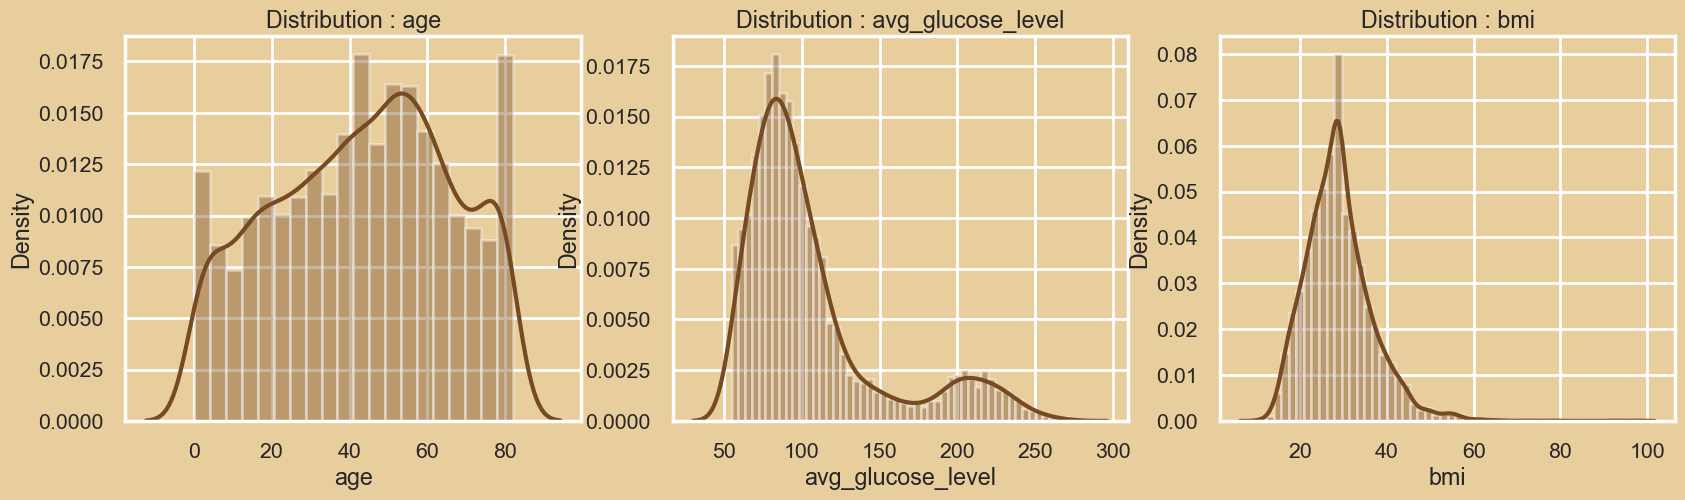

In [27]:
fig, ax = plt.subplots(nrows = 1,ncols = 3,figsize = (20,5))
for i in range(len(discrete_features)):
    plt.subplot(1,3,i+1)
    sns.distplot(df1[discrete_features[i]],color = palette[0])
    title = 'Distribution : ' + discrete_features[i]
    plt.title(title)
plt.show()

In [28]:
df1['age_group'] = [ int(i / 5) for i in df1['age']]
df1['avg_glucose_level_group'] = [ int(i / 20) for i in df1['avg_glucose_level']]
df1['bmi_group'] = [ int(i / 5) for i in df1['bmi']]

### Feature Engineering


- The dataset is **Unbalanced** with a bias towards **No Stroke** in a ratio of **19 : 1** for **No Stroke : Stroke**. We will first balance the dataset using **SMOTE Analysis**!

- In order to cope with unbalanced data, there are 2 options :

    - **Undersampling** : Trim down the majority samples of the target variable.
    - **Oversampling** : Increase the minority samples of the target variable to the majority samples.
    
- For best performances, combination of undersampling and oversampling is recommended.
- First, we will undersample the majority samples and it is followed by oversampling minority samples.
- For data balancing, we will use **imblearn**.
- **conda statement** : conda install imbalanced-learn

In [30]:
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [31]:
over = SMOTE(sampling_strategy = 1)
under = RandomUnderSampler(sampling_strategy = 0.1)
f1 = df1.loc[:,:'smoking_status']
t1 = df1.loc[:,'stroke']

steps = [('under', under),('over', over)]
pipeline = Pipeline(steps=steps)
f1, t1 = pipeline.fit_resample(f1, t1)
Counter(t1)

Counter({0: 2490, 1: 2490})

### Calculation for Data Balancing :

- **Sampling Strategy** : It is a ratio which is the common paramter for oversampling and undersampling.
- **Sampling Strategy** : **( Samples of Minority Class ) / ( Samples of Majority Class )**


- In this case,

    - **Majority Class : No Stroke** : 4861 samples
    - **Minority Class : Stroke** : 249 samples


### Undersampling : Trim down the majority class samples

- Sampling_Strategy = 0.1
- 0.1 = ( 249 ) / Majority Class Samples
- After undersampling, 

    - **Majority Class : No Stroke** : 2490 samples
    - **Minority Class : Stroke** : 249 samples


### Oversampling : Increase the minority class samples

- Sampling_Strategy = 1
- 1 = ( Minority Class Samples ) / 2490
- After oversampling, 

    - **Majority Class : No Stroke** : 2490 samples
    - **Minority Class : Stroke** : 2490 samples
    

- Final Class Samples :

    - **Majority Class : No Stroke** : 2490 samples
    - **Minority Class : Stroke** : 2490 samples


- Here, we balance the data by reducing the majority group samples & then increasing the minority group to majority group. 
- For imbalanced datasets, we **duplicate the data** to deal with the potential bias in the predictions. 
- Due to this duplication process, we are using **synthetic data** for modeling purposes to ensure that the predictions are not skewed towards the majority target class value.
- Thus, evaluating models using **accuracy** will be misleading. Instead, we will go for **confusion matrix, ROC-AUC graph and ROC-AUC score** for model evaluation.

### Data Leakage : 

- **Data Leakage** is the problem when the information outside the training data is used for model creation. It is one of the most ignored problem.
- In order to create robust models, solving data leakage is a must! Creation of overly optimistic models which are practically useless & cannot be used in production have become common.
- Model performance degrades when **Data Leakage** is not dealt with & the model is sent online. It is a difficult concept to understand because it seems quite trivial.
- Typical approach used is transforming / modifying the entire dataset by filling NAN values with mean, median & mode, standardisation, normalization, etc.
- When we execute the above process in order to make the dataset ready for modeling, we use the values from the entire dataset & thus indirectly provide information from the **to-be test data** i.e outside of the training data.
- Thus, in order to avoid **Data Leakage**, it is advised to use **train-test-split** before any transformations. Execute the transformations according to the training data for the training as well as test data. Use of k-fold cross validation is also suggested!
- We will display the effect of **Data Leakage** from the following code snippet!

In [32]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(f1, t1, test_size = 0.15, random_state = 2)


### Correlation Matrix :

In [33]:
x_train_test = x_train.copy(deep = True)
x_train_test['stroke'] = y_train

- In order to visualize the correlation matrix, we create a new dataframe that contains values from **x_train** & **y_train**.
- When we execute the above process in order to make the dataset ready for modeling, we use the values from the entire dataset & thus indirectly provide information from the **to-be test data** i.e outside of the training data.
- Thus, we reject anything outside the training data to avoid data leakage.


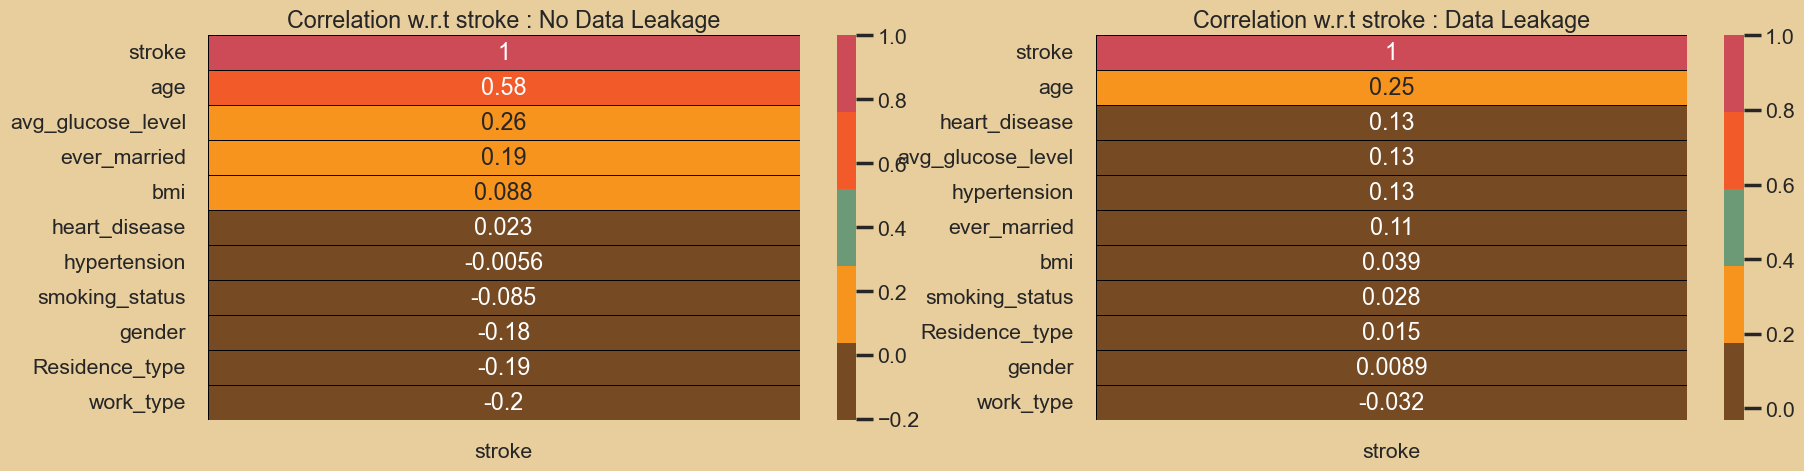

In [34]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (21,5))

plt.subplot(1,2,1)
corr = x_train_test.corrwith(x_train_test['stroke']).sort_values(ascending = False).to_frame()
corr.columns = ['stroke']
sns.heatmap(corr,annot = True,cmap = palette,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t stroke : No Data Leakage');

plt.subplot(1,2,2)
corr = df1.drop(columns = ['age_group', 'avg_glucose_level_group', 'bmi_group']).corrwith(df1['stroke']).sort_values(ascending = False).to_frame()
corr.columns = ['stroke']
sns.heatmap(corr,annot = True,cmap = palette,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t stroke : Data Leakage');

- Clearly, we can see the difference in values between **Data Leakage** & **No Data Leakage**.
- In the case of **No Data Leakage**, **age** displays a strong positive correlation with **stroke**. **avg_glucose_level** & **ever_married** display some kind of positive correlation. Opposite to positive correlation, **gender**, **Residence_type** & **work_type** have negative correlation with the **stroke**.
- In the case of **Data Leakage**, none of the features display an extreme positive or negative correlation with **stroke**.
- **age**, **heart_disease**, **avg_glucose_level**, **hypertension** & **ever_married** display some kind of positive correlation. Overall, all the features have a value very close to 0, displaying neutral correlation with **stroke**.

### Feature Selection for Categorical Features :

In [35]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif,chi2

/usr/local/Caskroom/miniforge/base/envs/py38_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


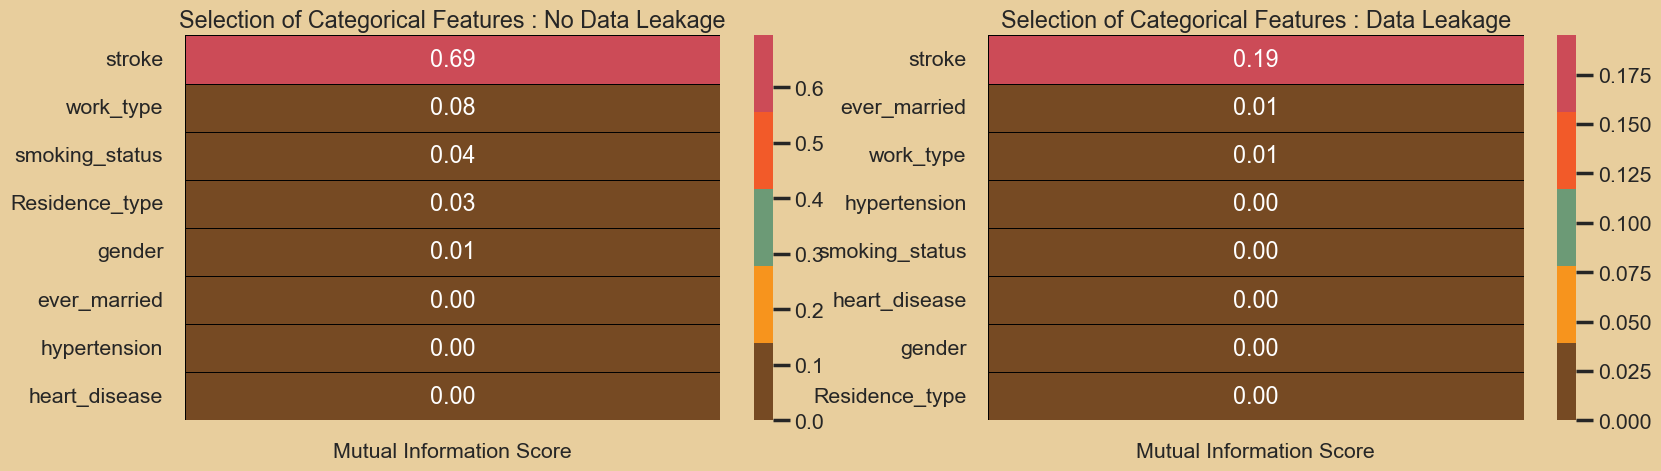

In [36]:
# Mutual Information Test :
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (19,5))

plt.subplot(1,2,1)
features = x_train_test.loc[:,categorical_features]
target = pd.DataFrame(y_train)

best_features = SelectKBest(score_func = mutual_info_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Mutual Information Score']) 
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Mutual Information Score'),annot = True,cmap = palette,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features : No Data Leakage');

plt.subplot(1,2,2)
features = df1.loc[:,categorical_features]
target = df1.loc[:,'stroke']

best_features = SelectKBest(score_func = mutual_info_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Mutual Information Score']) 
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Mutual Information Score'),annot = True,cmap = palette,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features : Data Leakage');

- Mutual Information Score of **stroke** with categorical features display very low scores irrespective of **Data Leakage** or **No Data Leakage**.
- According to the above scores, none of the features should be selected for modeling.

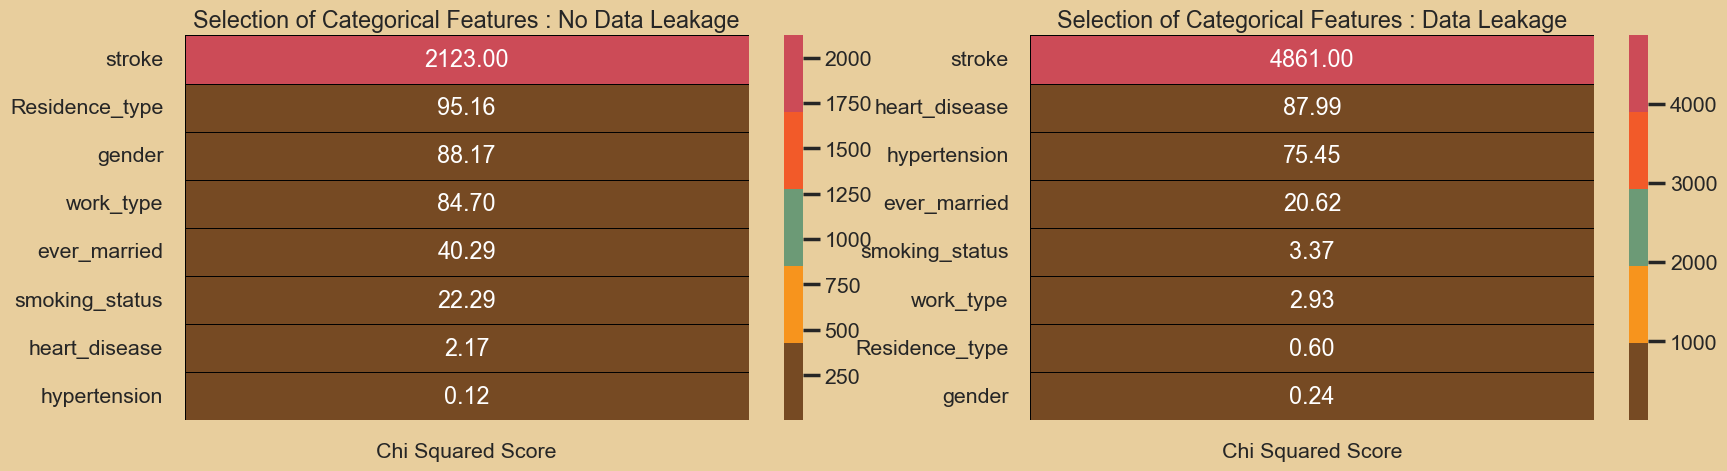

In [37]:
# Chi Squared Test :
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

plt.subplot(1,2,1)
features = x_train_test.loc[:,categorical_features]
target = y_train

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,cmap = palette,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features : No Data Leakage');

plt.subplot(1,2,2)
features = df1.loc[:,categorical_features]
target = df1.loc[:,'stroke']

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,cmap = palette,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features : Data Leakage');

- For **No Data Leakage**, we should reject the features that have low values. We will reject features with scores less than 35. Hence, we will not use : **smoking_status**, **heart_disease** & **hypertension**. This does contradict with the **Domain Information**.
- For **Data Leakage**, **heart disease** & **hypertension** need to be selected for modeling and reject the other features due to low Chi Squared Score. 

### Feature Selection for Numerical Features :

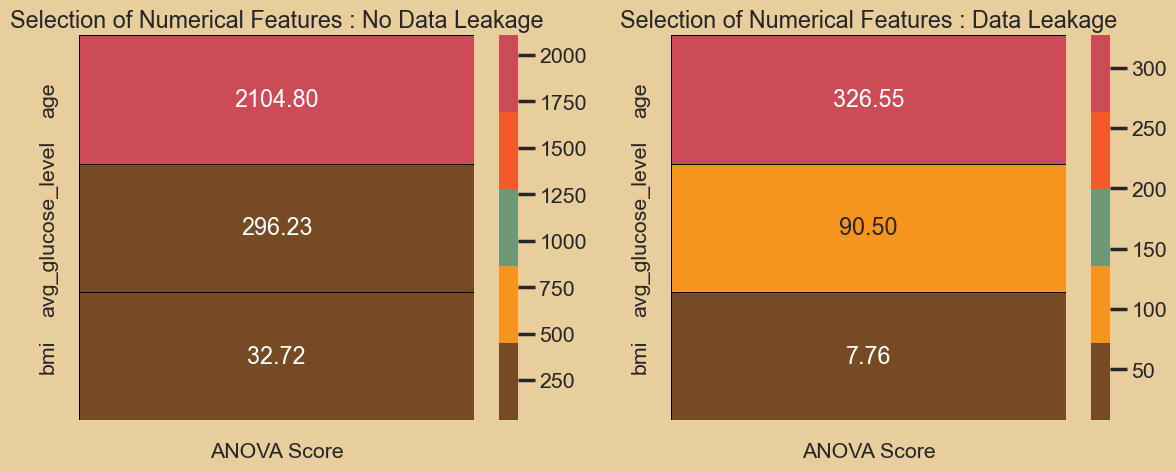

In [38]:
# Anova Test
from sklearn.feature_selection import f_classif

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14,5))

plt.subplot(1,2,1)
features = x_train.loc[:,discrete_features]
target = y_train

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap =palette,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features : No Data Leakage');

plt.subplot(1,2,2)
features = df1.loc[:,discrete_features]
target = df1.loc[:, 'stroke']

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = palette,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features : Data Leakage');

- From the above ANOVA Scores, we ignore the features with values less than 30. Hence, we reject **bmi** for modeling irrespective of **Data Leakage** or **No Data Leakage**.
- We ready the datasets for data scaling by dropping the features based on the above statistical tests.
- We will ignore the **Domain Information**!

In [39]:
# Feature Selection for No Data Leakage :
x_train = x_train.drop(columns = ['smoking_status', 'heart_disease', 'hypertension', 'bmi'])
x_test = x_test.drop(columns = ['smoking_status', 'heart_disease', 'hypertension', 'bmi'])

# Feature Selection for Data Leakage :
df2 = df1.drop(columns = ['smoking_status', 'work_type', 'Residence_type', 'gender', 
                          'bmi', 'age_group', 'avg_glucose_level_group', 'bmi_group']).copy(deep = True)

### Data Scaling :

- Machine learning model does not understand the units of the values of the features. It treats the input just as a simple number but does not understand the true meaning of that value. Thus, it becomes necessary to scale the data.

- We have 2 options for data scaling : 
    
    1) **Normalization** 
    
    2) **Standardization**. 


- As most of the algorithms assume the data to be normally (Gaussian) distributed, **Normalization** is done for features whose data does not display normal distribution and **standardization** is carried out for features that are normally distributed but the range of values is huge or small as compared to other features.

- From the above transformation, we fit the data on the training data and transform the test data from information based on the training data. If we check the formulas of the **Normalization** & **Standardization**, we use mean, standard deviation, min & max values.

- Thus if these above statistical parameters are calculated using the complete dataset, then we are sharing the values from the **to-be test data** and thus sharing this **to-be test data** with the training data and cause **Data Leakage**.

In [40]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

# No Data Leakage :

# Normalization
x_train['age'] = mms.fit_transform(x_train[['age']])
x_test['age'] = mms.transform(x_test[['age']])
x_train['avg_glucose_level'] = mms.fit_transform(x_train[['avg_glucose_level']])
x_test['avg_glucose_level'] = mms.transform(x_test[['avg_glucose_level']])

# Standardization
x_train['gender'] = ss.fit_transform(x_train[['gender']]); x_test['gender'] = ss.transform(x_test[['gender']])
x_train['ever_married'] = ss.fit_transform(x_train[['ever_married']]); x_test['ever_married'] = ss.transform(x_test[['ever_married']])
x_train['work_type'] = ss.fit_transform(x_train[['work_type']]); x_test['work_type'] = ss.transform(x_test[['work_type']])
x_train['Residence_type'] = ss.fit_transform(x_train[['Residence_type']]); x_test['Residence_type'] = ss.transform(x_test[['Residence_type']])

# Data Leakage :

# Normalization
df2['age'] = mms.fit_transform(df2[['age']])
df2['avg_glucose_level'] = mms.fit_transform(df2[['avg_glucose_level']])

# Standardization
df2['hypertension'] = mms.fit_transform(df2[['hypertension']])
df2['heart_disease'] = mms.fit_transform(df2[['heart_disease']])
df2['ever_married'] = mms.fit_transform(df2[['ever_married']])

### Modeling

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

In [42]:
x_train1, x_test1, y_train1, y_test1 = x_train.values, x_test.values, y_train.values, y_test.values
print(f"Shape of training data : {x_train1.shape}, {y_train1.shape}")
print(f"Shape of testing data : {x_test1.shape}, {y_test1.shape}")

Shape of training data : (4233, 6), (4233,)
Shape of testing data : (747, 6), (747,)


In [43]:
# Selecting the features from the above conducted tests and splitting the data into 85 - 15 train - test groups.
def model(classifier,x_train,y_train,x_test,y_test):
    
    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
    plot_roc_curve(classifier, x_test,y_test)
    plt.title('ROC_AUC_Plot')
    plt.show()

def model_evaluation(classifier,x_test,y_test):
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = palette,fmt ='')
    
    # Classification Report
    print(classification_report(y_test,classifier.predict(x_test)))

1] XGBoostClassifier :

Cross Validation Score :  91.31%
ROC_AUC Score :  83.43%


/usr/local/Caskroom/miniforge/base/envs/py38_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


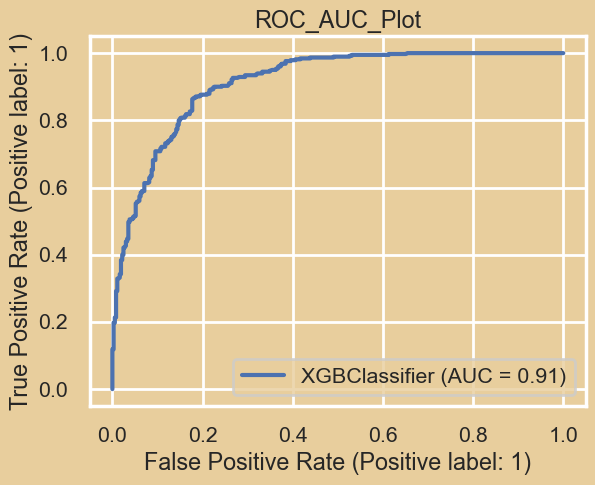

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       367
           1       0.81      0.89      0.85       380

    accuracy                           0.84       747
   macro avg       0.84      0.83      0.83       747
weighted avg       0.84      0.84      0.83       747



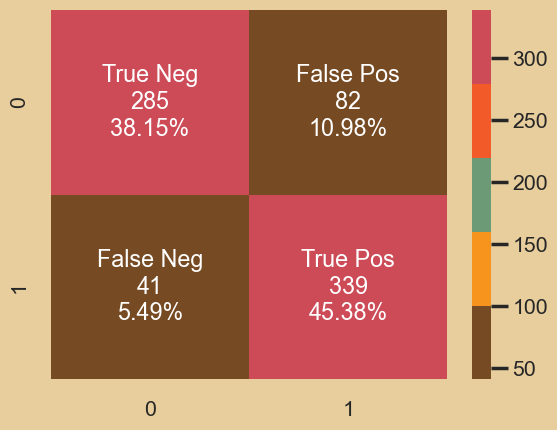

In [44]:
from xgboost import XGBClassifier
classifier_xgb = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)
model(classifier_xgb,x_train1,y_train1,x_test1,y_test1)
model_evaluation(classifier_xgb,x_test1,y_test1)

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [46]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)
lr_conf = confusion_matrix(y_test, lr_pred)
lr_report = classification_report(y_test, lr_pred)
lr_acc = round(accuracy_score(y_test, lr_pred)*100, ndigits = 2)
print(f"Confusion Matrix : \n\n{lr_conf}")
print(f"\nClassification Report : \n\n{lr_report}")
print(f"\nThe Accuracy of Logistic Regression is {lr_acc} %")

Confusion Matrix : 

[[282  85]
 [ 78 302]]

Classification Report : 

              precision    recall  f1-score   support

           0       0.78      0.77      0.78       367
           1       0.78      0.79      0.79       380

    accuracy                           0.78       747
   macro avg       0.78      0.78      0.78       747
weighted avg       0.78      0.78      0.78       747


The Accuracy of Logistic Regression is 78.18 %


In [47]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
gnb_pred = gnb.predict(x_test)
gnb_conf = confusion_matrix(y_test, gnb_pred)
gnb_report = classification_report(y_test, gnb_pred)
gnb_acc = round(accuracy_score(y_test, gnb_pred)*100, ndigits = 2)
print(f"Confusion Matrix : \n\n{gnb_conf}")
print(f"\nClassification Report : \n\n{gnb_report}")
print(f"\nThe Accuracy of Gaussian Naive Bayes is {gnb_acc} %")

Confusion Matrix : 

[[252 115]
 [ 62 318]]

Classification Report : 

              precision    recall  f1-score   support

           0       0.80      0.69      0.74       367
           1       0.73      0.84      0.78       380

    accuracy                           0.76       747
   macro avg       0.77      0.76      0.76       747
weighted avg       0.77      0.76      0.76       747


The Accuracy of Gaussian Naive Bayes is 76.31 %


In [48]:
bnb = BernoulliNB()
bnb.fit(x_train, y_train)
bnb_pred = bnb.predict(x_test)
bnb_conf = confusion_matrix(y_test, bnb_pred)
bnb_report = classification_report(y_test, bnb_pred)
bnb_acc = round(accuracy_score(y_test, bnb_pred)*100, ndigits = 2)
print(f"Confusion Matrix : \n\n{bnb_conf}")
print(f"\nClassification Report : \n\n{bnb_report}")
print(f"\nThe Accuracy of Bernoulli Naive Bayes is {bnb_acc} %")

Confusion Matrix : 

[[277  90]
 [179 201]]

Classification Report : 

              precision    recall  f1-score   support

           0       0.61      0.75      0.67       367
           1       0.69      0.53      0.60       380

    accuracy                           0.64       747
   macro avg       0.65      0.64      0.64       747
weighted avg       0.65      0.64      0.64       747


The Accuracy of Bernoulli Naive Bayes is 63.99 %


In [49]:
svm = SVC(C = 100, gamma = 0.002)
svm.fit(x_train, y_train)
svm_pred = svm.predict(x_test)
svm_conf = confusion_matrix(y_test, svm_pred)
svm_report = classification_report(y_test, svm_pred)
svm_acc = round(accuracy_score(y_test, svm_pred)*100, ndigits = 2)
print(f"Confusion Matrix : \n\n{svm_conf}")
print(f"\nClassification Report : \n\n{svm_report}")
print(f"\nThe Accuracy of Support Vector Machine is {svm_acc} %")

Confusion Matrix : 

[[271  96]
 [ 63 317]]

Classification Report : 

              precision    recall  f1-score   support

           0       0.81      0.74      0.77       367
           1       0.77      0.83      0.80       380

    accuracy                           0.79       747
   macro avg       0.79      0.79      0.79       747
weighted avg       0.79      0.79      0.79       747


The Accuracy of Support Vector Machine is 78.71 %


Cross Validation Score :  95.08%
ROC_AUC Score :  89.38%


/usr/local/Caskroom/miniforge/base/envs/py38_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


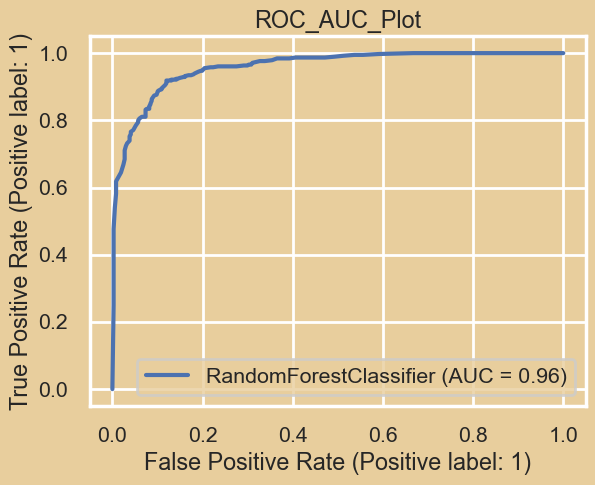

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       367
           1       0.88      0.92      0.90       380

    accuracy                           0.89       747
   macro avg       0.90      0.89      0.89       747
weighted avg       0.89      0.89      0.89       747



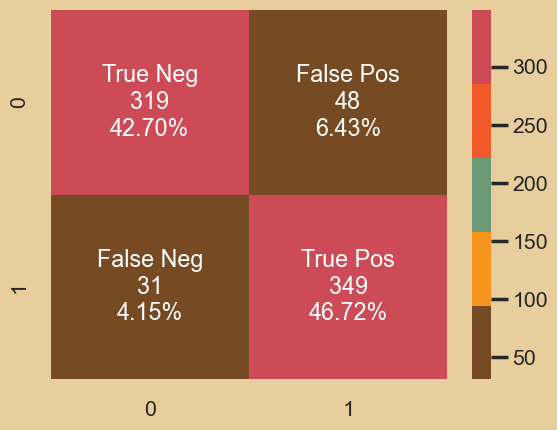

In [50]:
classifier_rf = RandomForestClassifier(n_estimators = 100, random_state = 42) 
model(classifier_rf,x_train1,y_train1,x_test1,y_test1)
model_evaluation(classifier_rf,x_test1,y_test1)

# rfg = RandomForestClassifier(n_estimators = 100, random_state = 42) 
# rfg.fit(x_train, y_train)
# rfg_pred = rfg.predict(x_test)
# rfg_conf = confusion_matrix(y_test, rfg_pred)
# rfg_report = classification_report(y_test, rfg_pred)
# rfg_acc = round(accuracy_score(y_test, rfg_pred)*100, ndigits = 2)
# print(f"Confusion Matrix : \n\n{rfg_conf}")
# print(f"\nClassification Report : \n\n{rfg_report}")
# print(f"\nThe Accuracy of Random Forest Classifier is {rfg_acc} %")

Cross Validation Score :  90.55%
ROC_AUC Score :  86.77%


/usr/local/Caskroom/miniforge/base/envs/py38_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


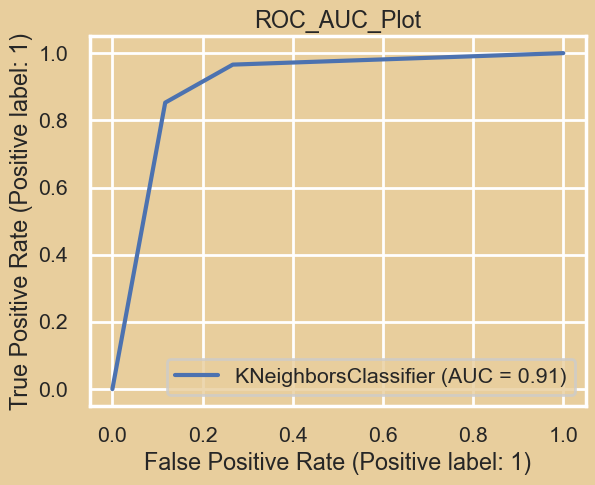

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       367
           1       0.88      0.85      0.87       380

    accuracy                           0.87       747
   macro avg       0.87      0.87      0.87       747
weighted avg       0.87      0.87      0.87       747



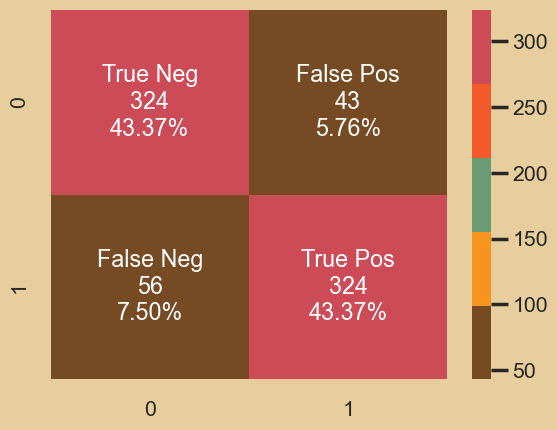

In [51]:
classifier_knn = KNeighborsClassifier(n_neighbors=2)
model(classifier_knn,x_train1,y_train1,x_test1,y_test1)
model_evaluation(classifier_knn,x_test1,y_test1)

# knn = KNeighborsClassifier(n_neighbors=2)
# knn.fit(x_train, y_train)
# knn_pred = knn.predict(x_test)
# knn_conf = confusion_matrix(y_test, knn_pred)
# knn_report = classification_report(y_test, knn_pred)
# knn_acc = round(accuracy_score(y_test, knn_pred)*100, ndigits = 2)
# print(f"Confusion Matrix : \n\n{knn_conf}")
# print(f"\nClassification Report : \n\n{knn_report}")
# print(f"\nThe Accuracy of K Nearest Neighbors Classifier is {knn_acc} %")

# <center><div style="font-family: Times New Roman; border-radius : 10px; color: #DF6589; padding: 12px; line-height: 1;">Conclusion</div></center>
### ML Alogrithm Results Table :
|Sr. No.|ML Algorithm|Cross Validation Score|ROC AUC Score|F1 Score (Stroke)|F1 Score (No Stroke)|
|-|-|-|-|-|-|
|1|Random Forest Classifier|95.43%|84.37%|90%|89%|
|2|K Nearest Neighbors Classifier|90.98%|88.22%|88%|88%|
|3|XGB Classifier|92.05%|82.38%|83%|81%|


### Deploy the model within Snowflake

In [52]:
rf= RandomForestClassifier(n_estimators = 100, random_state = 42) 
rf.fit(x_train, y_train)
# rfg_pred = rfg.predict(x_test)
# rfg_conf = confusion_matrix(y_test, rfg_pred)
# rfg_report = classification_report(y_test, rfg_pred)
# rfg_acc = round(accuracy_score(y_test, rfg_pred)*100, ndigits = 2)
# print(f"Confusion Matrix : \n\n{rfg_conf}")
# print(f"\nClassification Report : \n\n{rfg_report}")
# print(f"\nThe Accuracy of Random Forest Classifier is {rfg_acc} %")

RandomForestClassifier(random_state=42)

In [53]:
X_final=pd.concat([x_train,x_test],axis=0)
Y_final=pd.concat([y_train,y_test],axis=0)
df_final=pd.concat([X_final,Y_final],axis=1)

df_final=df_final.reset_index(drop=False)
df_final.head()


,index,gender,age,ever_married,work_type,Residence_type,avg_glucose_level,stroke
0,1815,1.424804,0.780488,0.603824,0.017221,1.212890,0.010161,0
1,307,-0.700353,0.524390,0.603824,-2.036151,-0.824477,0.007944,0
2,4974,-0.700353,0.707317,0.603824,-1.009465,-0.824477,0.656494,1
3,2937,-0.700353,0.951220,0.603824,-1.009465,1.212890,0.756615,1
4,2637,-0.700353,0.951220,0.603824,0.017221,1.212890,0.055745,1


In [54]:
# Create a Snowpark DF from the pandas DF
snowdf = session.create_dataframe(df_final)

create_temp_table is deprecated. We still respect this parameter when it is True but please consider using `table_type="temporary"` instead.


In [55]:
snowdf.show(2)

----------------------------------------------------------------------------------------------------------------------------------------------------------
|"index"  |"gender"             |"age"               |"ever_married"      |"work_type"           |"Residence_type"     |"avg_glucose_level"   |"stroke"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------
|1815     |1.424804365051237    |0.7804878048780488  |0.6038240485644457  |0.017220576392811923  |1.2128904845432755   |0.010160724182523562  |0         |
|307      |-0.7003530969860731  |0.524390243902439   |0.6038240485644457  |-2.0361512509529014   |-0.8244767460407265  |0.007943838906336598  |0         |
----------------------------------------------------------------------------------------------------------------------------------------------------------



In [56]:
# Loading customer data from Snowpark DF to a Snowflake internal table

snowdf.write.mode("overwrite").saveAsTable("patients_new") 

session.table("PATIENTS_NEW").limit(3).show(5)
# PATIENTS_NEW

----------------------------------------------------------------------------------------------------------------------------------------------------------
|"index"  |"gender"             |"age"               |"ever_married"      |"work_type"           |"Residence_type"     |"avg_glucose_level"   |"stroke"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------
|1815     |1.424804365051237    |0.7804878048780488  |0.6038240485644457  |0.017220576392811923  |1.2128904845432755   |0.010160724182523562  |0         |
|307      |-0.7003530969860731  |0.524390243902439   |0.6038240485644457  |-2.0361512509529014   |-0.8244767460407265  |0.007943838906336598  |0         |
|4974     |-0.7003530969860731  |0.7073170731707318  |0.6038240485644457  |-1.0094653372800446   |-0.8244767460407265  |0.6564938335481132    |1         |
----------------------------------------------------------------------

In [57]:
# Create a pandas data frame from the Snowflake table
custdf = session.table('PATIENTS_NEW').toPandas() 

print(f"'custdf' local dataframe created. Number of records: {len(custdf)} ")

'custdf' local dataframe created. Number of records: 4980 


In [58]:
# Define X and Y for modeling
X = custdf[[ "gender","age",
       "ever_married", "work_type","Residence_type","avg_glucose_level"]]
      
Y = custdf['stroke']

In [59]:
# Creating a User Defined Function within Snowflake to do the scoring there
def predict_pandas_udf(df: pd.DataFrame) -> pd.Series:
    return pd.Series(rf.predict(df))  

linear_model_vec = pandas_udf(func=predict_pandas_udf,
                                return_type=IntegerType(),
                                input_types=[FloatType(),FloatType(),FloatType(),FloatType(),FloatType(),FloatType()],
                                session=session,
                                packages = ("pandas","scikit-learn"), max_batch_size=200)